In [1]:
%load_ext watermark
%watermark -a "Bhavya Kohli" -v

Author: Bhavya Kohli

Python implementation: CPython
Python version       : 3.7.8
IPython version      : 7.30.0



# MoNuSAC Instance Segmentation

<a class = "anchor" id="datalink"></a>
This notebook aims to create a Mask-RCNN model using the MoNuSAC data available [**here**](https://monusac-2020.grand-challenge.org/Data/). Due to deprecation issues it is recommended to run this notebook in a virtual environment following the steps described in this [**README**](https://github.com/BhavyaKohli/MoNuSAC-Instance-Segmentation) (available in the repository).

# Contents <a id="top"></a>

1. [Extracting the Data](#extraction)
2. [Exploring the Extracted Data](#exploration)
3. [Using the Mask-RCNN model on the Data](#ml) <br>
    3.1. [Defining the Dataset class](#def_dataset) <br>
    3.2. [Defining the Model Configuration](#def_config) <br>
    3.3. [Defining the Model](#def_model) <br>
    3.4. [Analysis of the trained model](#analysis) <br>

We first confirm the versions of the main libraries, i.e. tensorflow (should be 1.15.0), keras (should be 2.2.5) and h5py (should be 2.10.0). 

In [2]:
%watermark -p tensorflow,keras,h5py

tensorflow: 1.15.0
keras     : 2.2.5
h5py      : 2.10.0



Using TensorFlow backend.


We then run the following cell to silence tensorflow deprecation warnings, since most of the functions and utilities used internally in the mask-rcnn library are deprecated in tensorflow versions 2.x

In [3]:
import tensorflow as tf

# Silence deprecated-function warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

After downloading the MoNuSAC data mentioned [here](#datalink), extract it to the same directory as the `monusac.ipynb` notebook
The structure of the working directory at this point should be:
```
.
├───MoNuSAC_images_and_annotations
├───sample_original
├───README.md
├───monusac_utils.py
└───monusac.ipynb (current notebook)
```

In [4]:
# Importing required libraries
import os, glob, pathlib
import numpy as np                      
import matplotlib.pyplot as plt

# For creating progress bars for "for" loops
import tqdm.notebook as tq          

A separate python file containing all created utility functions has been created. We import all those functions using the following cell:  

In [5]:
from monusac_utils import *

## Extracting the Data <a id="extraction"></a>
[Back to top](#top)

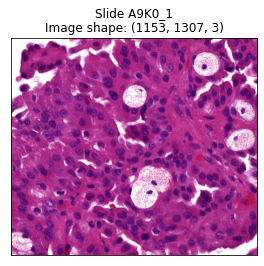

In [6]:
# Displaying a slide image using the above defined function
# using the sample slides in the sample_original directory.
sample_slides = glob.glob('./sample_original/*.svs')
img = from_svs(sample_slides[0], display = True, ax = plt.subplots()[1])

In [7]:
# Using the above defined function to store masks, slides, and annotations for
# 5 patients in the "data" folder (using default arguments)
data_path = './MoNuSAC_images_and_annotations/'

generate_and_save_masks(
    src = data_path,
    RESET=False,
    dst='./data',
    slides=False,
    masks=True,
    annots=False
)

Directory ./data already exists
Destination directories already exist. Please rename or delete in case of conflicting names.
209 slides are present in ./data\slides
394 masks are present in ./data\masks
209 annotations are present in ./data\annots


In [8]:
PATIENT_IDS = [filename[:6] for filename in os.listdir('./data/slides')]

In [9]:
# A few samples of the values stored in PATIENT_IDS
PATIENT_IDS[:5]

['1594_1', '1594_2', '1594_3', '1594_4', '1594_5']

In [10]:
create_train_test_data(
    RESET = False,
    slides_dir = './data/slides/', 
    patient_ids = PATIENT_IDS, 
    train = True, train_size = 0.8, 
    out_dir = './final'
)

create_train_test_data(
    RESET = False,
    slides_dir = './data/slides/', 
    patient_ids = PATIENT_IDS, 
    train = False, train_size = 0.8, 
    out_dir = './final'
)

Directory ./final exists
Directory ./final\train exists
755 slides were created at ./final\train
755 masks were created at ./final\train
Directory ./final exists
Directory ./final\val exists
206 slides were created at ./final\val
206 masks were created at ./final\val


After running the above cell, the working directory should now have the following structure:

```
.
├───data
│   ├───annots
│   ├───masks
│   │   ├───1
│   │   ├───2
│   │   ├───3
│   │   ├───4
│   │   └───X (One annotation file has an erroneous labelling.
|   |          The directory is created, but will be empty)
│   └───slides
├───final
│   ├───train
│   │   ├───slides
│   │   └───masks
│   └───val
│       ├───slides
│       └───masks
├───MoNuSAC_images_and_annotations
├───sample_original
├───README.md
├───monusac_utils.py
└───monusac.ipynb (current notebook)
```



## Exploring the extracted data <a id="exploration"></a>
[Back to top](#top)

In [11]:
# We create three lists containing paths for slides, masks and annotations.
# We can use these lists for creating plots for visualizing our data and the
# masks created using the `create_train_test_data` function

# Data locations
DATA_DIR = './final/'
ANNOTS_DIR = './data/annots/'

# Lists with paths
MASKS = [x.__str__() for x in pathlib.Path(DATA_DIR).glob('**/*.mask')]
MASK_IDS = [mask.split('\\')[-1][:-5] for mask in MASKS]
MASK_LABELS = [x.__str__() for x in pathlib.Path('./final/').glob('**/*.label')]

SLIDES = [x.__str__() for x in pathlib.Path(DATA_DIR).glob('**/*.png') if x.__str__().split('\\')[-1][:-4] in MASK_IDS]
IMAGE_IDS = [slide.split('\\')[-1][:-4] for slide in SLIDES if slide.split('\\')[-1][:-4] in MASK_IDS]

ANNOTS = [ANNOTS_DIR + filename for filename in os.listdir('./data/annots')]

In [12]:
SLIDES_uncropped = [x.__str__() for x in pathlib.Path('./data/').glob('**/*.png')]
MASKS_uncropped = [x.__str__() for x in pathlib.Path('./data/').glob('**/*.mask')]

In [13]:
find_in_list('7760_1', MASKS_uncropped)

['data\\masks\\2\\lym_7760_1.mask', 'data\\masks\\4\\neu_7760_1.mask']

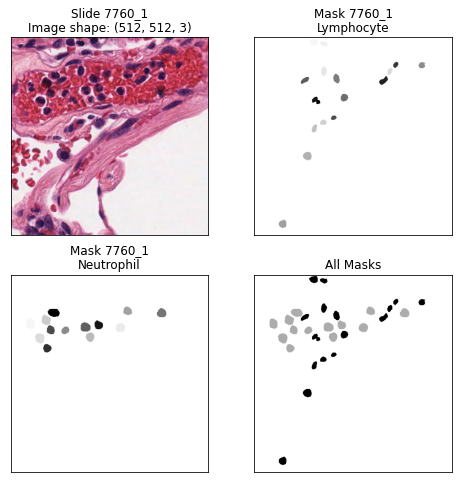

In [14]:
fig, axes = plt.subplots(2,2,figsize=(8,8))
show_slide(find_in_list('7760_1', SLIDES_uncropped)[0], return_img = False, ax = axes[0,0], read_mode = 'cv2')
example_list = find_in_list('7760_1', MASKS_uncropped)

for i, loc in zip(example_list, [(0,1), (1,0)]):
    show_mask(i, return_mask = False, ax = axes[loc])
    
mask_1 = modify_mask_values(show_mask(example_list[0]), 0.7)
mask_2 = modify_mask_values(show_mask(example_list[1]), 0.3)

all_in_one =  mask_1 + mask_2

clean_plot(all_in_one, axes[1,1], "All Masks", "Greys")
plt.show()

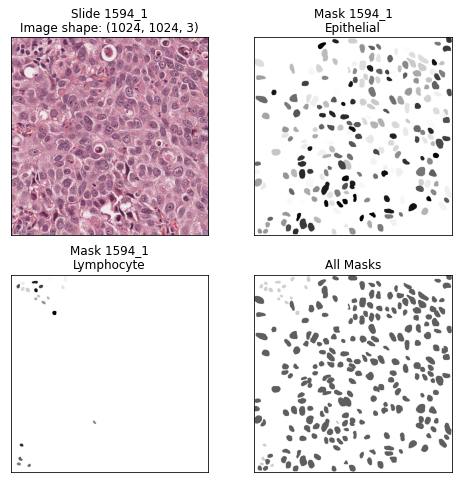

In [15]:
fig, axes = plt.subplots(2,2,figsize=(8,8))
show_slide(find_in_list('1594_1', SLIDES_uncropped)[0], return_img = False, ax = axes[0,0], read_mode = 'cv2')
example_list = find_in_list('1594_1', MASKS_uncropped)

for i, loc in zip(example_list, [(0,1), (1,0)]):
    show_mask(i, return_mask = False, ax = axes[loc])
    
mask_1 = modify_mask_values(show_mask(example_list[0]), 0.7)
mask_2 = modify_mask_values(show_mask(example_list[1]), 0.3)

all_in_one =  mask_1 + mask_2

clean_plot(all_in_one, axes[1,1], "All Masks", "Greys")
plt.show()

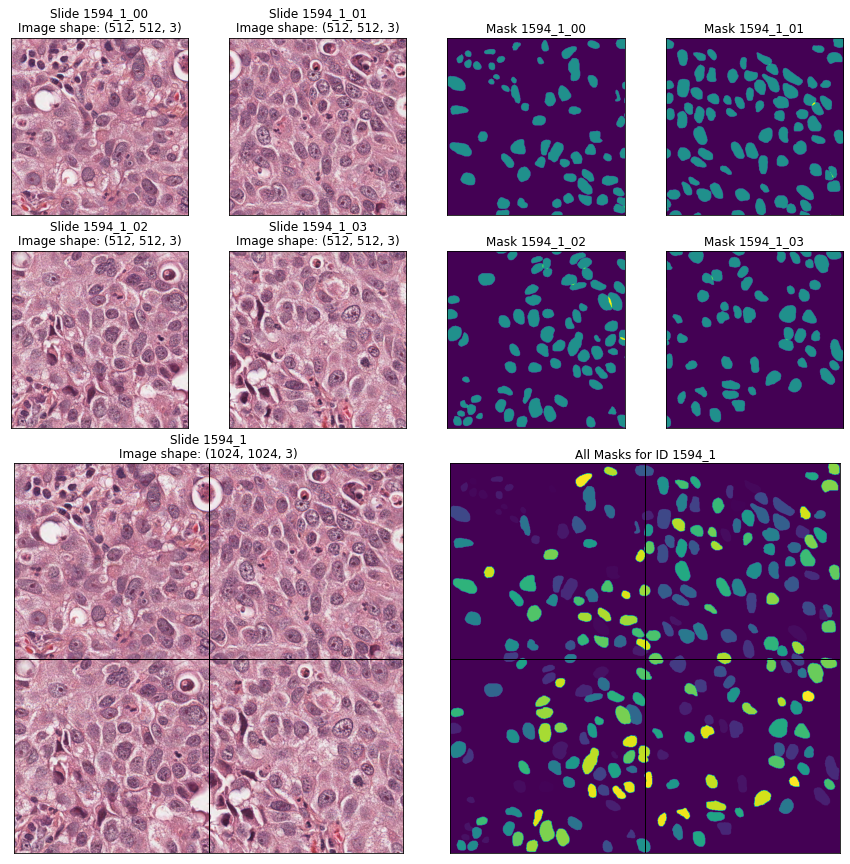

In [16]:
# Checking whether the cropped images are indeed correct by 
# comparing all subparts and the main image

fig = plt.figure(figsize=(15, 15))
gs = plt.GridSpec(4, 4)

locs1 = [(0,0), (0,1), (1,0), (1,1)]
locs2 = [(0,2), (0,3), (1,2), (1,3)]

slide_axes = []
for slide, loc in zip(find_in_list('1594_1', SLIDES), locs1):
    slide_axes.append(fig.add_subplot(gs[loc]))
    show_slide(slide, return_img = False, read_mode = 'cv2', ax = slide_axes[-1])

mask_axes = []
for mask, loc in zip(find_in_list('1594_1', MASKS), locs2):
    mask_axes.append(fig.add_subplot(gs[loc]))
    show_mask(mask, return_mask = False, ax = mask_axes[-1], cmap = None)

total_slide = fig.add_subplot(gs[2:,:2])
show_slide(find_in_list('1594_1', SLIDES_uncropped)[0], return_img = False, ax = total_slide)
total_slide.axvline(512, color = 'black', linewidth = 1)
total_slide.axhline(512, color = 'black', linewidth = 1)

total_mask = fig.add_subplot(gs[2:,2:])
clean_plot(combine_masks(collect_masks_for_id('1594_1', MASKS_uncropped)), return_mask = False, ax = total_mask, title = "All Masks for ID 1594_1")
total_mask.axvline(512, color = 'black', linewidth = 1)
total_mask.axhline(512, color = 'black', linewidth = 1)

plt.show()

## Using the Mask-RCNN model on the data <a id="ml"></a>
[Back to top](#top)

In [17]:
# Importing required utilities from the mask-rcnn library
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import utils
from mrcnn.model import MaskRCNN
from mrcnn import visualize

import copy
from sklearn.model_selection import train_test_split
import imgaug.augmenters as iaa

### Creating arrays of data and applying augmentations

In [18]:
class model_input():
    def __init__(self, id, patient_id, path, labels = None, label_path = None, isAugmented = False, augmentations = None):
        self.id = id
        self.patient_id = patient_id
        self.path = path
        
        self.type = 'mask' if '.mask' in path else 'image'
        self.isAugmented = isAugmented
        self.augmentations = augmentations

        if self.type == 'mask':
            self.labels = labels
            self.labels_path = label_path

        #if self.type == 'mask': self.mask = data
        #elif self.type == 'image': self.image = data  

In [19]:
def load_and_augment_data(num = None, 
                          augment = True,
                          prob_augment = 0.33, 
                          augmentation_types = ["rotate", "scale"], 
                          rotate = (-50,50), scale = (0.9,1.4),
                          seed = 1):
    
    np.random.seed(seed)
    augmentations_dict = {
        "rotate": iaa.Affine(rotate = rotate),
        "shift": iaa.Affine(translate_px={"x": (-20,20), "y": (-10,10)}),
        "scale": iaa.Affine(scale = scale)
        # add more here
    }
    
    MASKS_DIR = f'./final/masks/'
    SLIDES_DIR = f'./final/slides/'

    slides_list = os.listdir(SLIDES_DIR)

    images = np.array([])
    masks = np.array([])

    idx = 0
    num_augmented = 0
    for filename in tq.tqdm(slides_list[:num], ncols = 75):
        image_id = idx
        patient_id = filename.split('.')[0][:6] 
        img_path = pathlib.Path(os.path.join(SLIDES_DIR, filename)).__str__()
        mask_path = pathlib.Path(os.path.join(MASKS_DIR, filename.split('.')[0] + '.mask')).__str__()
        mask_labels_path = pathlib.Path(os.path.join(MASKS_DIR, filename.split('.')[0] + '.label')).__str__()
        mask_labels = feather.read_dataframe(mask_labels_path).values 

        #image = show_slide(img_path)
        #mask = show_mask(mask_path)

        images = np.append(images, model_input(image_id, patient_id, img_path))
        masks = np.append(masks, model_input(image_id, patient_id, mask_path, mask_labels, mask_labels_path))

        if '_aug' in img_path:
            images[-1].isAugment = True
            masks[-1].isAugment = True
            
        idx += 1

        if augment:
            augment_trigger = np.random.choice([0,1], p=[1 - prob_augment, prob_augment])
            if augment_trigger: 
                augmented_image = copy.deepcopy(images[-1])
                augmented_mask = copy.deepcopy(masks[-1])
                
                queued_list = []
                num_augments = 0
                for augmentation_type in augmentation_types:
                    if augmentation_type not in augmentations_dict.keys():
                        print("Please use an available augmentation method from :",
                            "1. rotate",
                            "2. shift",
                            "3. scale", sep = '\n'
                        )
                        continue

                    if num_augments: trigger = np.random.choice([0,1])
                    else: trigger = 1

                    if trigger:
                        aug_func = augmentations_dict[augmentation_type].to_deterministic()
                        queued_list.append((augmentation_type, aug_func))
                    num_augments += 1

                if queued_list:
                    augmented_image.isAugmented = True
                    augmented_image.augmentations = queued_list
                    augmented_image.id = idx
                    images = np.append(images, augmented_image)

                    augmented_mask.isAugmented = True
                    augmented_mask.augmentations = queued_list
                    augmented_mask.id = idx
                    masks = np.append(masks, augmented_mask)

                    idx += 1
                    num_augmented += 1
    
    print(f"An additional {num_augmented} images and masks have been created")
    return images, masks

In [20]:
data_images, data_masks = load_and_augment_data(num = None, 
                                                augment = False,
                                                prob_augment = 0.5, 
                                                augmentation_types = ["rotate", "scale"], 
                                                rotate = (-30,30), scale = (0.9,1.4), 
                                                seed = 42)

100%|███████████████████████████████████| 961/961 [00:01<00:00, 555.22it/s]

An additional 500 images and masks have been created


In [22]:
def augment_and_filter_data(images, masks, RESET = False):
    all_files = [x.__str__() for x in pathlib.Path('./final/').glob('**/*')]
    if RESET:
        for filepath in all_files:
            if 'aug' in filepath:
                os.remove(filepath)

    exceptions = []
    for img, msk in tq.tqdm(zip(images, masks), total = len(images), ncols = 75):        
        if img.isAugmented and not 'aug' in img.path:
            image_save_path = img.path.split('.')[0] + '_aug.png'
            mask_save_path = msk.path.split('.')[0] + '_aug.mask'
            mask_label_save_path = msk.labels_path.split('.')[0] + '_aug.label'

            if os.path.exists(image_save_path): continue

            image = show_slide(img.path)
            mask = show_mask(msk.path)
            mask_labels = msk.labels

            filtered_mask, filtered_labels = filter_cropped_mask(mask, mask_labels, 'all')
        
            for aug in img.augmentations:
                aug_type = aug[0]
                aug_func = aug[1]
                try:
                    image = aug_func.augment_image(image)
                    filtered_mask = aug_func.augment_image(filtered_mask)

                    filtered_mask, filtered_labels = filter_cropped_mask(filtered_mask, filtered_labels, 'all')
                except:
                    print(f"{aug_type} failed on {img.id}")

            try:
                assert filtered_mask.shape[2] == len(filtered_labels)
                assert filtered_mask.shape[:2] == image.shape[:2]
                #print(filtered_mask.shape, len(filtered_labels), image.shape)

                cv2.imwrite(image_save_path, image)  
                images[img.id].path = image_save_path
            
                mask_1d = np.append(filtered_mask.flatten(), filtered_mask.shape)
                feather.write_dataframe(pd.DataFrame(mask_1d), mask_save_path)
                feather.write_dataframe(pd.DataFrame(filtered_labels), mask_label_save_path)
                masks[img.id].path = mask_save_path
                masks[img.id].labels_path = mask_label_save_path

            except:
                exceptions.append(img.id)

    images = np.delete(images, exceptions)
    masks = np.delete(masks, exceptions)

    count_aug = ['aug' in filepath for filepath in all_files]
    print(f"Saved {np.sum(count_aug)} augmented images and masks")
    
    return images, masks

In [23]:
data_images, data_masks = augment_and_filter_data(data_images, data_masks, RESET = True)

 94%|████████████████████████████████  | 1378/1461 [21:03<00:36,  2.29it/s]

rotate failed on 1381


100%|██████████████████████████████████| 1461/1461 [21:55<00:00,  1.11it/s]

Saved 27 augmented images and masks


In [24]:
# Sanity check

print("Number of slides :", len(glob.glob('final/slides/*.png')))
print("Number of masks : ", len(glob.glob('final/masks/*.mask')))
print("Number of mask labels : ", len(glob.glob('final/masks/*.label')))

Number of slides : 1459
Number of masks :  1459
Number of mask labels :  1459


In [26]:
# Checking number of images and masks in the above arrays, and 
# confirming that no image id is being repeated

print(len(data_images), len(data_masks), len(np.unique([im.id for im in data_images])))

1459 1459 1459


In [27]:
train_images, val_images, train_masks, val_masks = train_test_split(data_images, data_masks, train_size = 0.8, random_state = 1)

### Defining the dataset class <a id="def_class"></a>

We now define the dataset class which inherits the base class utils.Dataset from the library. The load function is the basic function which will have to be run each time a dataset is created using this class. It adds all the necessary information about images such as image id, location of annotations, location of slides, etc. to the dataset. All these will then be used in the load_mask and load_image functions (internally) to add the images themselves to the dataset.

In [29]:
class MonuData(utils.Dataset):

    def load(self, image_array, mask_array):
        self.add_class("cell", 1, "Epithelial")
        self.add_class("cell", 2, "Lymphocyte")
        self.add_class("cell", 3, "Macrophage")
        self.add_class("cell", 4, "Neutrophil")

        assert len(image_array) == len(mask_array), "Length of the images and masks arrays are not equal"

        for img, msk in zip(image_array, mask_array):
            self.add_image('cell', 
                           image_id = img.id, 
                           patient_id = img.patient_id, 
                           path = img.path, 
                           mask_path = msk.path,
                           mask_labels_path = msk.labels_path,
                           isAugmented = img.isAugmented,
                           augmentations = img.augmentations)
    
    def load_image(self, image_id, ax = None):
        info = self.image_info[image_id]
        slide_path = info['path']
        img = show_slide(slide_path, read_mode = 'cv2')

        return img

    def load_mask(self, image_id, mask_filter = 'all'):
        info = self.image_info[image_id]
        mask_path = info['mask_path']
        mask_label_path = info['mask_labels_path']

        mask = show_mask(mask_path)
        mask_labels = feather.read_dataframe(mask_label_path).values 
        filtered_mask, filtered_labels = filter_cropped_mask(mask, mask_labels, mask_filter)

        try: 
            dummy = filtered_mask.shape
        except: 
            filtered_mask = mask
            filtered_labels = mask_labels
            
        return filtered_mask.astype(bool), np.array(filtered_labels).reshape(-1,)

    def num_cells(self, image_id, mask_filter = 'all'):
        info = self.image_info[image_id]
        mask_path = info['mask']
        mask_label_path = info['mask_labels']

        mask = show_mask(mask_path)
        mask_labels = feather.read_dataframe(mask_label_path).values 

        _, filtered_labels = filter_cropped_mask(mask, mask_labels, mask_filter)
        return len(filtered_labels)

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        print(info)
        return info['path']#

In [30]:
# Creating the training dataset
train_dataset = MonuData()
train_dataset.load(train_images, train_masks)
train_dataset.prepare()

# Creating the validation dataset
val_dataset = MonuData()
val_dataset.load(val_images, val_masks)
val_dataset.prepare()

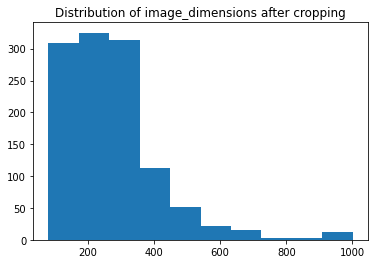

In [31]:
image_dims = [train_dataset.load_image(i).shape[0] for i in train_dataset.image_ids]
plt.hist(image_dims)
plt.title("Distribution of image_dimensions after cropping")
plt.show()

In [33]:
# Confirming that the load_mask function works as intended
load_mask_test = train_dataset.load_mask(1)
print(f"Shape of created mask: {load_mask_test[0].shape}", 
      f"Types of masks created: {np.unique([label_mapping[i] for i in load_mask_test[1]])}",
      "Info about the image:\n" + str(train_dataset.image_info[1]).replace(', ', ',\n '), sep = '\n')

print(f"Total matches for the corresponding patient id in the masks archive:\n {find_in_list(train_dataset.image_info[2]['patient_id'], MASKS_uncropped)}")

Shape of created mask: (276, 309, 15)
Types of masks created: ['Epithelial' 'Lymphocyte']
Info about the image:
{'id': 598,
 'source': 'cell',
 'path': 'final\\slides\\A1X5_2_05_aug.png',
 'patient_id': 'A1X5_2',
 'mask_path': 'final\\masks\\A1X5_2_05_aug.mask',
 'mask_labels_path': 'final\\masks\\A1X5_2_05_aug.label',
 'isAugmented': True,
 'augmentations': [('rotate',
 Affine(name=UnnamedAffine,
 parameters=[Deterministic(float 1.00000000),
 Deterministic(int 0),
 Uniform(Deterministic(int -30),
 Deterministic(int 30)),
 Deterministic(float 0.00000000),
 Deterministic(int 1),
 Deterministic(int 0),
 Deterministic(constant),
 auto],
 deterministic=True)),
 ('scale',
 Affine(name=UnnamedAffine,
 parameters=[Uniform(Deterministic(float 0.90000000),
 Deterministic(float 1.40000000)),
 Deterministic(int 0),
 Deterministic(float 0.00000000),
 Deterministic(float 0.00000000),
 Deterministic(int 1),
 Deterministic(int 0),
 Deterministic(constant),
 auto],
 deterministic=True))]}
Total matche

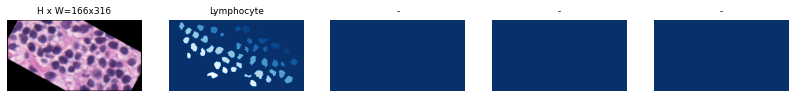

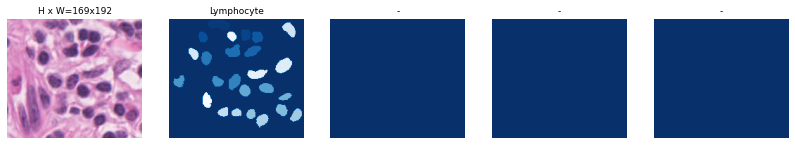

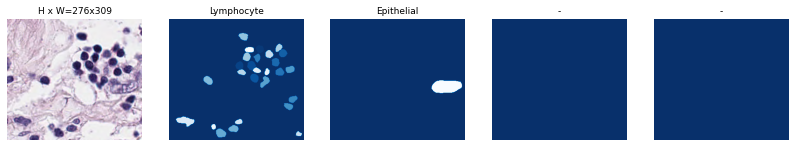

In [34]:
# Visualizing masks for a few slides using the "visualize" utility
image_ids = np.random.choice(train_dataset.image_ids, 3)
for image_id in image_ids:
    image = train_dataset.load_image(image_id)
    mask, class_ids = train_dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, train_dataset.class_names)

### Confirming whether the augmentations applied to masks and images are indeed the same 

In [35]:
sub = train_dataset.image_ids[:100]
sub_augmented = [i for i in sub if train_dataset.image_info[i]['isAugmented']] 

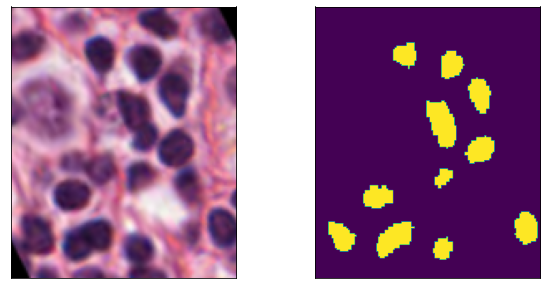

In [45]:
_, axes = plt.subplots(1,2,figsize=(10,5))

index = np.random.choice(len(sub_augmented))
img1 = train_dataset.load_image(sub_augmented[index])
msk1, lab1 = train_dataset.load_mask(sub_augmented[index])
clean_plot(img1, axes[0])
clean_plot(combine_masks(msk1), axes[1])

plt.show()

### Defining the model configuration <a id="def_config"></a>

We inherit the base configuration class from mrcnn.config and override the default values according to the specs of our dataset. We have 4 cell types and so the number of classes have to be set to **5**, which is 1 (background) + 4 (number of unique cell types). Image minimum and maximum dimensions have been set to 256 each, looking at the dimension distribution in the histogram above. Minimum detection confidence has been set to 80% for training.

In [46]:
# Finding the mean R, G and B values of the images in the train dataset
ids = train_dataset.image_ids
RGB = np.zeros((len(ids),3))

for k in ids:
    img = train_dataset.load_image(k)
    RGB[k] = np.array([np.mean(img[:,:,2]), np.mean(img[:,:,1]), np.mean(img[:,:,0])])

In [47]:
np.mean(RGB, axis = 0)

array([161.30647419, 124.84524   , 168.60021968])

In [48]:
# Defining the configuration
class MonuConfig(Config):
    NAME = 'MoNuSAC'

    IMAGES_PER_GPU = 1 

    # Background + 4 cell types         
    NUM_CLASSES = 1 + 4

    # Setting steps per epoch as the length of the datasets
    STEPS_PER_EPOCH = len(train_dataset.image_ids)   
    VALIDATION_STEPS = len(val_dataset.image_ids)
    
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    MAX_GT_INSTANCES = 200
    DETECTION_MAX_INSTANCES = 200

    # Setting Mean values of R,G,B calculated above 
    MEAN_PIXEL = np.mean(RGB, axis = 0)         

    # Setting minimum confidence to 80%
    DETECTION_MIN_CONFIDENCE = 0.8
    
    # Minimum image size
    IMAGE_MIN_DIM = 128

    # Maximum image size
    IMAGE_MAX_DIM = 256

    RPN_TRAIN_ANCHORS_PER_IMAGE = 150

cfg = MonuConfig()
cfg.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        200
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

### Defining the model and training it using the datasets created <a id="def_model"></a>

In [49]:
# loads model weights using this
MODEL_WEIGHTS_PATH = '../mask_rcnn_coco.h5'

# saves logs and checkpoint model weights in this directory
LOGS_PATH = './logs'

if not os.path.exists(MODEL_WEIGHTS_PATH):
    utils.download_trained_weights(MODEL_WEIGHTS_PATH)

In [50]:
# MODEL_WEIGHTS_PATH = find_in_list('0001', [x.__str__() for x in pathlib.Path('./logs').glob('**/*.h5')])[0]
# For continuing training, load the weights of the best saved model

model = MaskRCNN(mode = "training", config = cfg, model_dir = LOGS_PATH)

model.load_weights(
    MODEL_WEIGHTS_PATH, 
    by_name=True, 
    exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"]
)

In [51]:
from keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor = 'val_loss', patience = 3)

In [52]:
model.train(
    train_dataset = train_dataset, 
    val_dataset = val_dataset, 
    learning_rate = 10*cfg.LEARNING_RATE, 
    epochs = 15, 
    layer_verbosity = 0,
    layers = '3+',
    custom_callbacks = [es_callback]
)


Starting at epoch 0. LR=0.01

Checkpoint Path: ./logs\monusac20211224T2227\mask_rcnn_monusac_{epoch:04d}.h5


c:\Users\bhavy\MoNuSAC-Instance-Segmentation\monusac\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\Users\bhavy\MoNuSAC-Instance-Segmentation\monusac\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\Users\bhavy\MoNuSAC-Instance-Segmentation\monusac\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/15
1167/1167 [==============================] - 2292s 2s/step - loss: 1.6799 - rpn_class_loss: 0.1208 - rpn_bbox_loss: 0.4623 - mrcnn_class_loss: 0.4191 - mrcnn_bbox_loss: 0.3441 - mrcnn_mask_loss: 0.3336 - val_loss: 1.4338 - val_rpn_class_loss: 0.0713 - val_rpn_bbox_loss: 0.3601 - val_mrcnn_class_loss: 0.4241 - val_mrcnn_bbox_loss: 0.2741 - val_mrcnn_mask_loss: 0.3042
Epoch 2/15
1167/1167 [==============================] - 1941s 2s/step - loss: 1.2843 - rpn_class_loss: 0.0710 - rpn_bbox_loss: 0.3422 - mrcnn_class_loss: 0.3144 - mrcnn_bbox_loss: 0.2509 - mrcnn_mask_loss: 0.3058 - val_loss: 1.2745 - val_rpn_class_loss: 0.0701 - val_rpn_bbox_loss: 0.4074 - val_mrcnn_class_loss: 0.2654 - val_mrcnn_bbox_loss: 0.2326 - val_mrcnn_mask_loss: 0.2990
Epoch 3/15
1167/1167 [==============================] - 1818s 2s/step - loss: 1.1415 - rpn_class_loss: 0.0648 - rpn_bbox_loss: 0.2987 - mrcnn_class_loss: 0.2658 - mrcnn_bbox_loss: 0.2214 - mrcnn_mask_loss: 0.2908 - val_loss: 1.1878 - val_rp

In [34]:
# MODEL_WEIGHTS_PATH = find_in_list('0003', [x.__str__() for x in pathlib.Path(LOGS_PATH).glob('**/*.h5')])[-1]
# For continuing training, load the weights of the saved model

model = MaskRCNN(mode = "training", config = cfg, model_dir = LOGS_PATH)

model.load_weights(
    MODEL_WEIGHTS_PATH, 
    by_name=True, 
    exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"]
)

Re-starting from epoch 3


In [35]:
from keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor = 'val_loss', patience = 3)

In [ ]:
model.train(
    train_dataset = train_dataset, 
    val_dataset = val_dataset, 
    learning_rate = 2*cfg.LEARNING_RATE, 
    epochs = 6,
    layer_verbosity = 0, 
    layers = '3+',
    custom_callbacks = [es_callback]
)

### Further analysis and visualizations using the trained model <a id="analysis"></a>

In [53]:
from collections import Counter

In [54]:
# Defining a new configuration for Inference
class InferenceConfig(cfg.__class__):
    DETECTION_MIN_CONFIDENCE = 0.7

inf_cfg = InferenceConfig()

In [55]:
weights_list = find_in_list('0011', [x.__str__() for x in pathlib.Path(LOGS_PATH).glob('**/*.h5')])
print(*[(i,j) for i,j in enumerate(weights_list)], sep = '\n')
print("Input the index of the desired weights : ")
idx = int(input())

# Using the model weights from previous runs for model evaluation.
WEIGHTS_PATH = weights_list[idx]
print("Weights seleted :", WEIGHTS_PATH[5:])

# Defining model in 'inference' mode
model_trained = MaskRCNN(mode = 'inference', config = inf_cfg, model_dir = LOGS_PATH)
model_trained.load_weights(WEIGHTS_PATH, by_name = True)

(0, 'logs\\monusac20211205T0107\\mask_rcnn_monusac_0011.h5')
(1, 'logs\\monusac20211213T1950\\mask_rcnn_monusac_0011.h5')
(2, 'logs\\monusac20211224T2227\\mask_rcnn_monusac_0011.h5')
Input the index of the desired weights : 
Weights seleted : monusac20211224T2227\mask_rcnn_monusac_0011.h5
Re-starting from epoch 11


{'id': 1212, 'source': 'cell', 'path': 'final\\slides\\A9K0_2_05_aug.png', 'patient_id': 'A9K0_2', 'mask_path': 'final\\masks\\A9K0_2_05_aug.mask', 'mask_labels_path': 'final\\masks\\A9K0_2_05_aug.label', 'isAugmented': True, 'augmentations': [('rotate', Affine(name=UnnamedAffine, parameters=[Deterministic(float 1.00000000), Deterministic(int 0), Uniform(Deterministic(int -30), Deterministic(int 30)), Deterministic(float 0.00000000), Deterministic(int 1), Deterministic(int 0), Deterministic(constant), auto], deterministic=True)), ('scale', Affine(name=UnnamedAffine, parameters=[Uniform(Deterministic(float 0.90000000), Deterministic(float 1.40000000)), Deterministic(int 0), Deterministic(float 0.00000000), Deterministic(float 0.00000000), Deterministic(int 1), Deterministic(int 0), Deterministic(constant), auto], deterministic=True))]}
image ID: 276, cell-1212 final\slides\A9K0_2_05_aug.png


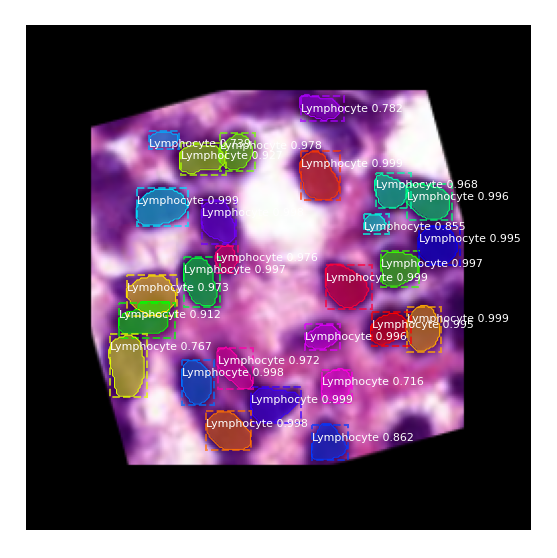

Cell types detected : {'Lymphocyte': 27}
Actual cell types present : {'Lymphocyte': 23}
Number of cells detected : 27
Actual number of cells present : 23
Original image and mask displayed below for comparison: 


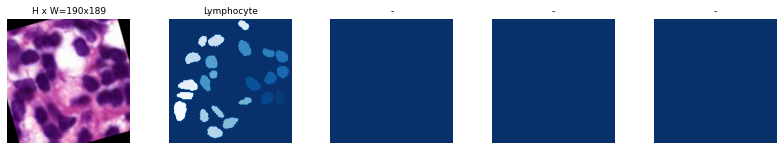

In [57]:
image_id = np.random.choice(val_dataset.image_ids)

image = modellib.load_image_gt(val_dataset, inf_cfg, image_id, use_mini_mask=False)[0]
info = val_dataset.image_info[image_id]
print(f"image ID: {image_id}, {info['source']}-{info['id']} {val_dataset.image_reference(image_id)}")
image_x, image_y = image.shape[:2]

#image = val_dataset.load_image(image_id)
results = model_trained.detect([image], verbose=0)

r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], val_dataset.class_names, r['scores'], figsize = (10,10))

# Loading the original image, mask and class_ids from the dataset
image = val_dataset.load_image(image_id)
mask, class_ids = val_dataset.load_mask(image_id)

actual_classes = dict(Counter([label_mapping[id] for id in class_ids]))
num_present = np.sum([actual_classes[key] for key in actual_classes.keys()])
result_classes = dict(Counter([label_mapping[id] for id in r['class_ids']]))
num_detected = np.sum([result_classes[key] for key in result_classes.keys()])

print(
    f"Cell types detected : {result_classes}",
    f"Actual cell types present : {actual_classes}",
    f"Number of cells detected : {num_detected}",
    f"Actual number of cells present : {num_present}",
    "Original image and mask displayed below for comparison: ",
    sep = '\n'
)

visualize.display_top_masks(image, mask, class_ids, val_dataset.class_names)

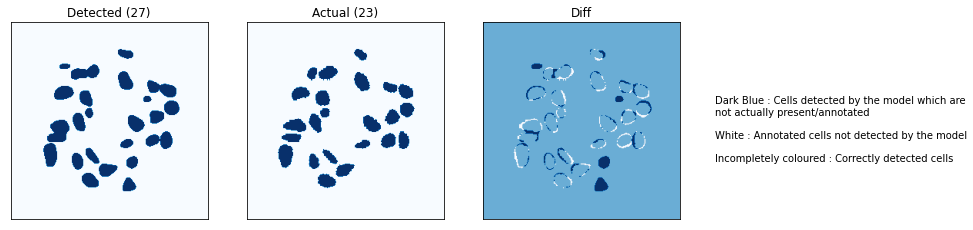

In [58]:
pred_mask = combine_masks(r['masks'])[:,:,0]
actual_mask = combine_masks(mask)[:,:,0]#cv2.resize(combine_masks(mask), r['masks'].shape[:2])
actual_mask = resize_with_padding(actual_mask, (pred_mask.shape))

_, ax = plt.subplots(1,3,figsize=(12,4))
clean_plot(pred_mask, ax[0], f"Detected ({num_detected})", cmap = "Blues")
clean_plot(actual_mask, ax[1], f"Actual ({num_present})", cmap = "Blues")
clean_plot(np.ones(r['masks'].shape[:2]) + pred_mask - actual_mask, ax[2], "Diff", cmap = "Blues")
ax[2].text(300, 120, "Dark Blue : Cells detected by the model which are\nnot actually present/annotated")
ax[2].text(300, 150, "White : Annotated cells not detected by the model")
ax[2].text(300, 180, "Incompletely coloured : Correctly detected cells")
plt.show()

## Misc. Testing

In [ ]:
m = get_mask('1594_1')[0]
m.shape

In [ ]:
np.savetxt('txt.txt', m.flatten())

In [ ]:
import pandas as pd
import feather

In [ ]:
feather.write_dataframe(pd.DataFrame(m.flatten()), 'txt.feather')

64


  0%|          | 0/63 [00:00<?, ?it/s]

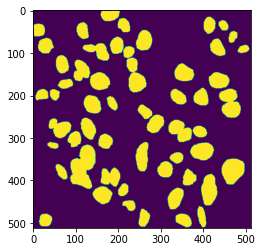

In [ ]:
plt.imshow(combine_masks(feather.read_dataframe('txt.feather').values.reshape(m.shape)))

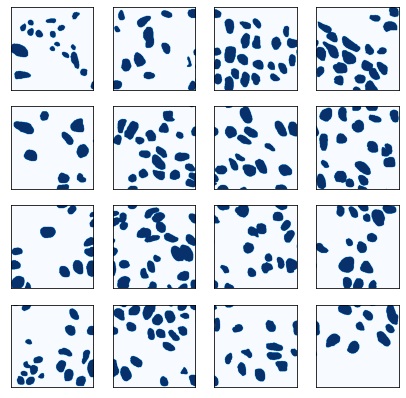

In [ ]:
masks = crop_mask(m, 256, 256)
_, axes = plt.subplots(4, 4, figsize = (7,7))

for i, j in zip(masks.keys(), [(i,j) for i in np.arange(4) for j in np.arange(4)]):
    clean_plot(combine_masks(masks[i]), axes[j], cmap = "Blues")

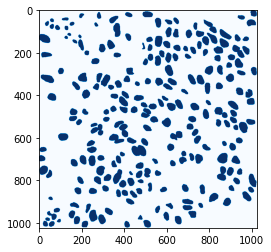

In [ ]:
plt.imshow(combine_masks(m), cmap = "Blues")

In [ ]:
mask = feather.read_dataframe('./ignore/test/train/masks/1594_1_02.feather').values.reshape(512,512,251)
filtered_mask, _ = filter_cropped_mask(mask, [1 for i in range(251)])

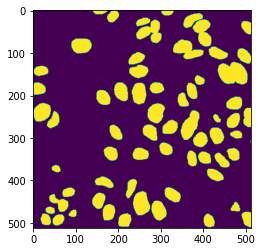

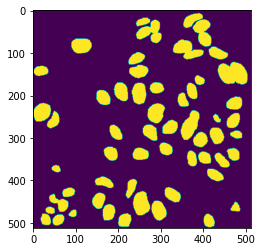

In [ ]:
plt.imshow(combine_masks(mask))
plt.show()
plt.imshow(combine_masks(filtered_mask))
plt.show()

In [ ]:
class MonuData(utils.Dataset):

    def load(self, train):
        type = 'train' if train else 'val'
        MASKS_DIR = f'./final/{type}/masks/'
        SLIDES_DIR = f'./final/{type}/slides/'

        self.add_class("cell", 1, "Epithelial")
        self.add_class("cell", 2, "Lymphocyte")
        self.add_class("cell", 3, "Macrophage")
        self.add_class("cell", 4, "Neutrophil")

        slides_list = os.listdir(SLIDES_DIR)
        train_len = int(0.8 * len(slides_list))

        for filename, idx in zip(slides_list, np.arange(len(slides_list))):
            image_id = idx
            patient_id = filename.split('.')[0][:6] 
            img_path = pathlib.Path(os.path.join(SLIDES_DIR, filename)).__str__()
            mask_path = pathlib.Path(os.path.join(MASKS_DIR, filename.split('.')[0] + '.mask')).__str__()
            mask_labels_path = pathlib.Path(os.path.join(MASKS_DIR, filename.split('.')[0] + '.label')).__str__()

            if train and idx > train_len:
                continue
            if not train and idx < train_len + 1:
                continue
            
            self.add_image('cell', 
                           image_id = image_id, 
                           patient_id = patient_id, 
                           path = img_path, 
                           mask = mask_path,
                           mask_labels = mask_labels_path)
    
    def load_image(self, image_id, ax = None):
        info = self.image_info[image_id]
        slide_path = info['path']
        img = show_slide(slide_path, read_mode = 'cv2')
        
        return img

    def load_mask(self, image_id, mask_filter = 'all'):
        info = self.image_info[image_id]
        mask_path = info['mask']
        mask_label_path = info['mask_labels']

        mask = show_mask(mask_path)
        mask_labels = feather.read_dataframe(mask_label_path).values 

        filtered_mask, filtered_labels = filter_cropped_mask(mask, mask_labels, mask_filter)
        return filtered_mask.astype(bool), np.array(filtered_labels).reshape(-1,)

    def num_cells(self, image_id, mask_filter = 'all'):
        info = self.image_info[image_id]
        mask_path = info['mask']
        mask_label_path = info['mask_labels']

        mask = show_mask(mask_path)
        mask_labels = feather.read_dataframe(mask_label_path).values 

        _, filtered_labels = filter_cropped_mask(mask, mask_labels, mask_filter)
        return len(filtered_labels)

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        print(info)
        return info['path']#